In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(tickers=[ticker], start=start_date, end=end_date, interval="1d")
    data['Pct Change'] = data['Close'].pct_change() * 100
    data = data.dropna()
    data.drop(columns=['High', 'Low', 'Adj Close'], inplace =True)
    data.reset_index(inplace=True)
    
    # plt.figure()
    # plt.plot(data['Date'], data['Close'])
    # plt.title(f"Daily {ticker} Price", fontsize=16)
    # plt.xlabel('Date', fontsize=14)
    # plt.ylabel('Price', fontsize=14)
    # plt.grid(True)
    # plt.show()

    # plt.figure()
    # plt.plot(data['Date'], data['Pct Change'])
    # plt.title(f"Daily {ticker} Percentage Change", fontsize=16)
    # plt.xlabel('Date', fontsize=14)
    # plt.ylabel('Percentage Change', fontsize=14)
    # plt.grid(True)
    # plt.show()
    return data

def get_index(data, date):
    return data[data['Date'] == date].index[0]

def sliding_window(x, window_size):
    out = np.empty((0, window_size))
    for i in range(len(x)-window_size+1):
        out = np.vstack((out, x[i:i+window_size]))
    return out

def plot_autocorr(data, lag):
    fig, ax = plt.subplots()
    plot_acf(data, lags=lag, zero=False, ax=ax)
    ax.set_ylim(-0.2, 0.2)
    return

def construct_price_from_pct(pct_array, initial_value):
    price = np.zeros(len(pct_array)+1)
    price[0] = initial_value
    for i in range(1, len(pct_array)+1):
        price[i] = price[i-1]*(1+pct_array[i-1]/100)
    return price

def plot_tsne(real_samples, generated_samples):
    tsne = TSNE(n_components=2)
    generated_samples = generated_samples.detach()
    all_data = np.concatenate([real_samples, generated_samples], axis=0)
    embedding = tsne.fit_transform(all_data)
    plt.figure()
    plt.title("T-SNE Plot")
    plt.scatter(embedding[:len(real_samples), 0], embedding[:len(real_samples), 1], label="Real", alpha=0.5)
    plt.scatter(embedding[len(real_samples) :, 0], embedding[len(real_samples) :, 1], label="Generated", alpha=0.5)
    plt.legend()

def plot_umap(real_samples, generated_samples):
    reducer = umap.UMAP()
    generated_samples = generated_samples.detach()
    all_data = np.concatenate([real_samples, generated_samples], axis=0)
    embedding = reducer.fit_transform(all_data)
    plt.figure()
    plt.title("UMAP Plot")
    plt.scatter(embedding[:len(real_samples), 0], embedding[:len(real_samples), 1], label="Original", alpha=0.5)
    plt.scatter(embedding[len(real_samples) :, 0], embedding[len(real_samples) :, 1], label="Generated", alpha=0.5)
    plt.legend()
    
def plot_hist(real_data, synthetic_data):
    plt.figure()
    bins = np.linspace(np.min(real_data) ,np.max(real_data) ,100)
    plt.hist(real_data, bins=bins, label='real data')
    plt.hist(synthetic_data, bins=bins, alpha=0.5, label='synthetic data')
    plt.title('Real vs Generated Samples Distribution')
    plt.xlabel("Daily Return (%)") 
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()
    
def MSE_calculation(data, start_idx, end_idx, col0, *cols):
    df = data.iloc[start_idx:end_idx]
    MSE = np.zeros(len(cols))
    for i, col in enumerate(cols):
        MSE[i] = np.mean((df[col0]-df[col])**2)
    return MSE

def month_MSE(data, start_month, end_month, col0, *cols):
    month_range = pd.date_range(start=start_month, end=end_month, freq='MS')
    MSE = np.zeros((len(month_range),len(cols)))
    start_year = int(start_month[:4])
    for j in range(len(cols)):
        for i in range(len(month_range)):
            df = data[(data['Date'].dt.year == start_year+i//12) & (data['Date'].dt.month == i%12+1)]
            MSE[i,j] = np.mean((df[col0]-df[cols[j]])**2)

    plt.figure(figsize=(12,6))
    for j in range(len(cols)):
        plt.plot(month_range, MSE[:,j], marker='o', label=cols[j])
    plt.title('MSE of Prediction', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Square Error', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()
    return MSE

def moving_block_bootstrap(data, block_length, num_samples):
    num_obs = len(data)
    output = []
    for i in range(int(num_samples//block_length)):
        start_index = np.random.randint(0, num_obs - block_length + 1)
        output = output + (list(data[start_index:start_index+block_length]))
    return np.array(output)

def train_ARIMA(x, order):
    model = ARIMA(x, order=order)
    model_fit = model.fit()
    return model_fit

def predict_ARIMA_pct(data, window_size, col_val, col_chg, order, start, end, model_trained):
    pct_prediction = np.zeros(len(data))
    price_prediction = np.zeros(len(data))
    for i in range(start, end):
        df = data.iloc[i-window_size:i]
        x = np.array(df[col_chg])
        x = np.flip(x)
        x = np.insert(x, 0, 1)
        params = np.array(model_trained.params)[:-1]
        params = np.array(model_trained.params)[:-1]
        pct_prediction[i] = np.dot(params,x)
        price_prediction[i] = (1+pct_prediction[i]/100) * data.iloc[i-1][col_val]
    return pct_prediction, price_prediction

In [83]:
#Define GAN
class Discriminator(nn.Module):
    def __init__(self, real_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(real_size, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
class Generator(nn.Module):
    def __init__(self, latent_size, real_size, scaler):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(latent_size, 32),
             nn.ReLU(),
             nn.Linear(32, 128),
             nn.ReLU(),
             nn.Linear(128, 512),
             nn.ReLU(),
             nn.Linear(512, real_size),
         )

        self.scaler = scaler

    def forward(self, x):
        output = self.model(x)
        return output

    def generate(self, num_samples, real_dim, latent_dim):
        num_samples = int(num_samples/real_dim)
        random_samples = torch.rand((num_samples, latent_dim))
        out = self.model(random_samples)
        out = out.detach()
        out = self.scaler.inverse_transform(out)
        out = out.reshape(-1)
        return out

In [93]:
# Define function for training GAN
def train_GAN(data, window_size, latent_dim, lr, num_epochs, batch_size, loss_function):
    #Window Sliding
    real_dim = window_size
    real_data = sliding_window(data, window_size)
    
    #Load data
    scaler = StandardScaler()
    real_data = scaler.fit_transform(real_data)
    real_data = torch.tensor(real_data, dtype=torch.float32)
    data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)
    
    #Initialize model
    discriminator = Discriminator(real_dim)
    generator = Generator(latent_dim,real_dim, scaler)
    gen_loss_vector = []
    discr_loss_vector = []
    num_epoch_vector = []
    
    #Use Adam algorithm to update weights of generator and discriminator
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        for n, real_samples in enumerate(data_loader):
            
            # Data for training the discriminator
            sample_size = len(real_samples)
            real_samples_labels = torch.ones((sample_size, 1))
            random_samples = torch.rand((sample_size, latent_dim))
            generated_samples = generator(random_samples)
            generated_samples_labels = torch.zeros((sample_size, 1))      
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
    
            # Training the discriminator
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            optimizer_discriminator.zero_grad()
            loss_discriminator.backward()
            optimizer_discriminator.step()
    
            # Data for training the generator
            random_samples = torch.rand((sample_size, latent_dim))
            generated_samples = generator(random_samples)
            output_discriminator_generated = discriminator(generated_samples)
            
            #Training the generator
            optimizer_generator.zero_grad()
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
            
        if epoch % 5 == 0:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)
    
        # Show loss
        if epoch % int(num_epochs/2) == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            # Generate low dimensional plot
            plot_tsne(real_samples, generated_samples)
            plot_umap(real_samples, generated_samples)
            
            # Visualize Distribution
            num_synthetic = len(data)
            synthetic_data = generator.generate(num_synthetic, real_dim, latent_dim)
            plot_hist(data, synthetic_data)
            
    #Plot generator loss
    plt.figure()
    plt.plot(num_epoch_vector, gen_loss_vector) 
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    #Plot discriminator loss
    plt.figure()
    plt.plot(num_epoch_vector, discr_loss_vector) 
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return generator

In [85]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, real_dim, latent_dim, scaler):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(real_dim, int(real_dim/2)), 
            nn.ReLU(),
            nn.Linear(int(real_dim/2), int(real_dim/4)),
            nn.ReLU(),
            nn.Linear(int(real_dim/4), latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, int(real_dim/4)), 
            nn.ReLU(),
            nn.Linear(int(real_dim/4), int(real_dim/2)),
            nn.ReLU(),
            nn.Linear(int(real_dim/2), real_dim),
        )
        self.scaler = scaler

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def generate(self, num_samples, real_dim, latent_dim):
        num_samples = int(num_samples/real_dim)
        print(num_samples)
        random_samples = torch.rand((num_samples, latent_dim))
        out = self.decoder(random_samples)
        out = out.detach()
        out = self.scaler.inverse_transform(out)
        out = out.reshape(-1)
        return out

In [86]:
def train_AE(data, window_size, latent_dim, lr, num_epochs, batch_size, loss_function):
    #Window Sliding
    real_dim = window_size
    real_data = sliding_window(data, window_size)
    
    #Load data
    scaler = StandardScaler()
    real_data = scaler.fit_transform(real_data)
    real_data = torch.tensor(real_data, dtype=torch.float32)
    data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)

    #Initialize model
    model = Autoencoder(real_dim, latent_dim, scaler)
    loss_vector = []
    num_epoch_vector = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    for epoch in range(num_epochs):
        for n, real_samples in enumerate(data_loader):
            generated_samples = model(real_samples)
            loss = loss_function(generated_samples, real_samples)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            loss_vector.append(float(loss))
            num_epoch_vector.append(epoch)

        if epoch % int(num_epochs/2) == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
            
            # Generate low dimensional plot
            plot_tsne(real_samples, generated_samples)
            plot_umap(real_samples, generated_samples)
    
            # Visualize Distribution
            num_synthetic = len(data)
            print(num_synthetic)
            synthetic_data = model.generate(num_synthetic, real_dim, latent_dim)
            plot_hist(data, synthetic_data)
    
    #Plot generator loss
    plt.figure()
    plt.plot(num_epoch_vector, loss_vector) 
    plt.title('Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    return model

In [95]:
data = load_stock_data('GOOGL', '2015-12-31', '2023-12-31')
# plot_autocorr(data['Pct Change'], 30)
i2017 = get_index(data, '2017-01-03')
i2019 = get_index(data, '2019-01-02')
i2020 = get_index(data, '2020-01-02')
i2021 = get_index(data, '2021-01-04')
i2022 = get_index(data, '2022-01-03')
i2023 = get_index(data, '2023-01-03')

train_index = i2019
test_index = i2023
data_train =  np.array(data.iloc[0:train_index]['Close'])
data_test = np.array(data.iloc[train_index:]['Close'])

[*********************100%%**********************]  1 of 1 completed


Epoch: 0 Loss D.: 0.6879683136940002
Epoch: 0 Loss G.: 0.64963698387146


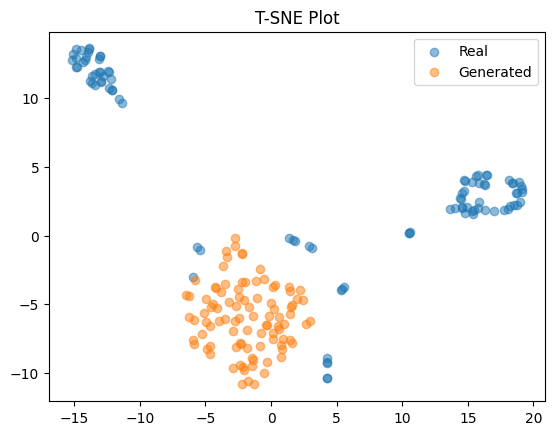

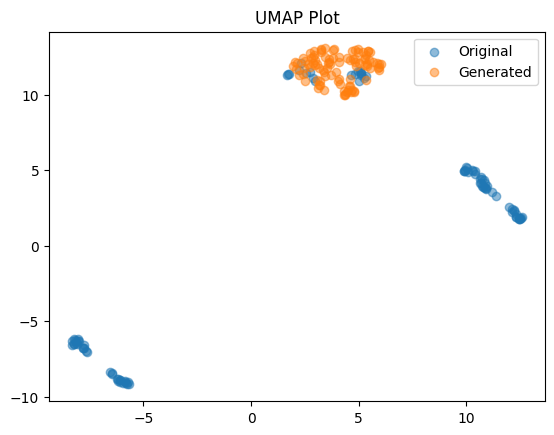

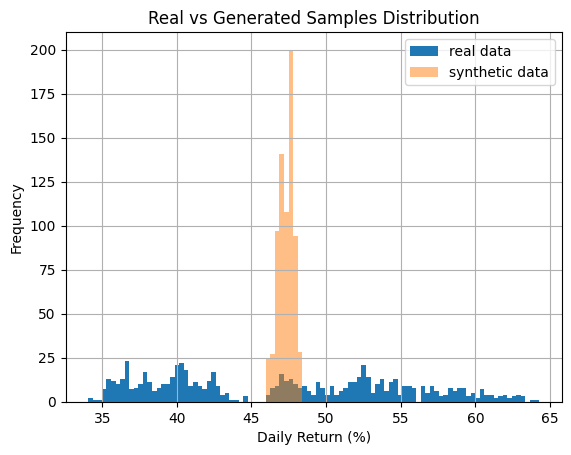

Epoch: 500 Loss D.: 0.6177273988723755
Epoch: 500 Loss G.: 2.1886396408081055


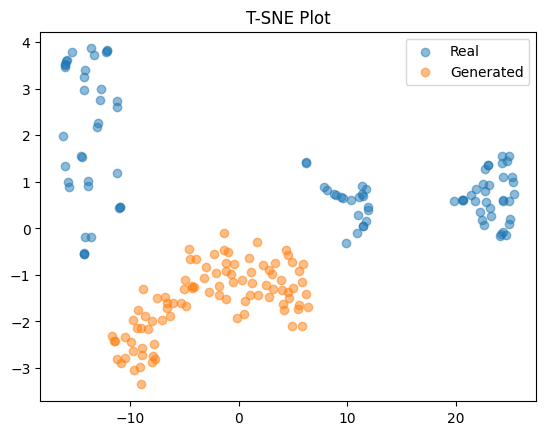

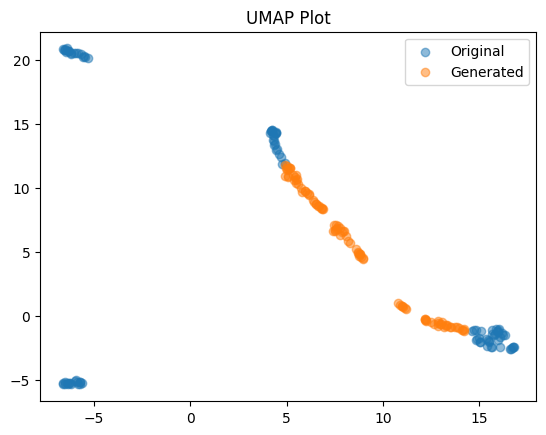

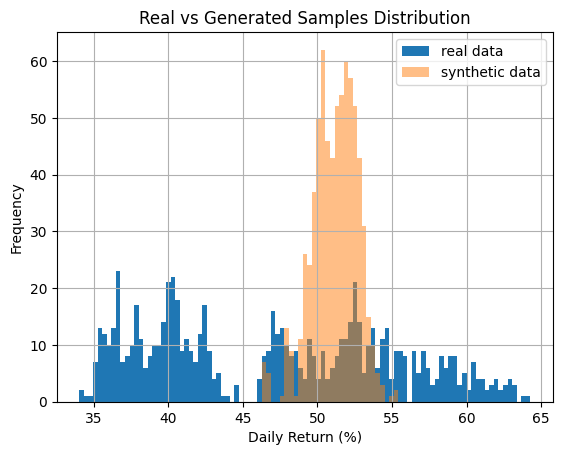

Epoch: 1000 Loss D.: 0.15240876376628876
Epoch: 1000 Loss G.: 3.769357204437256


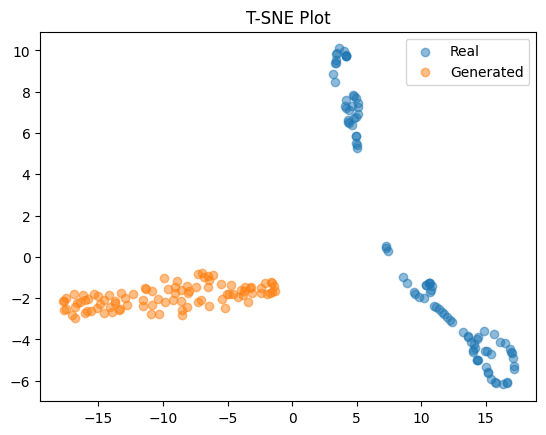

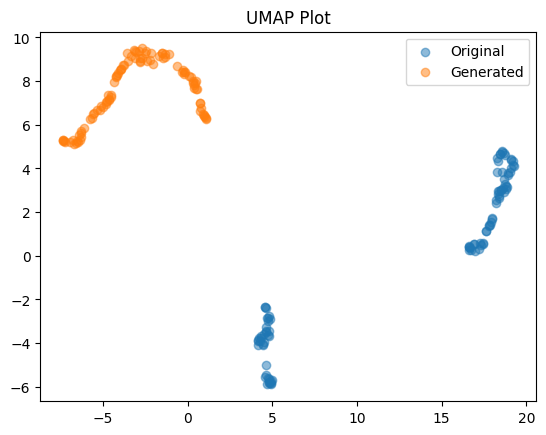

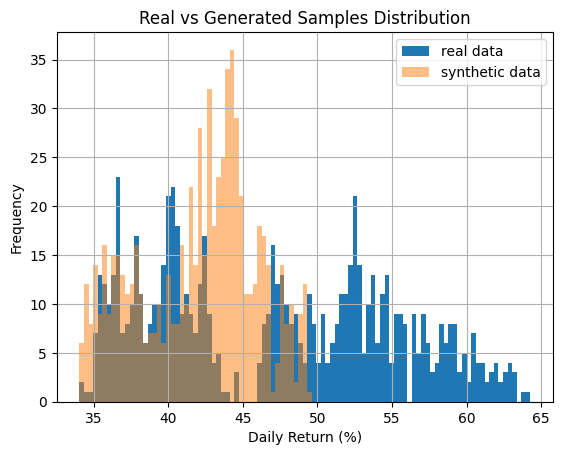

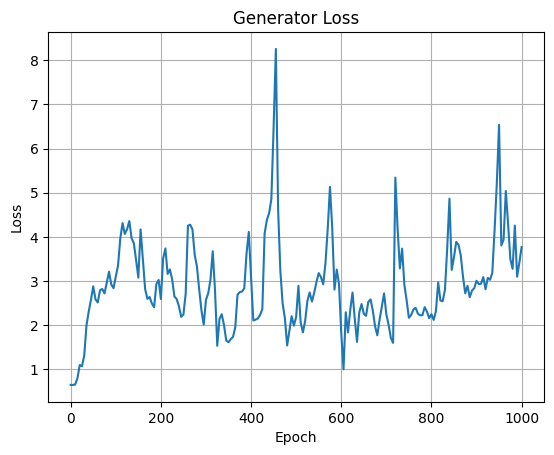

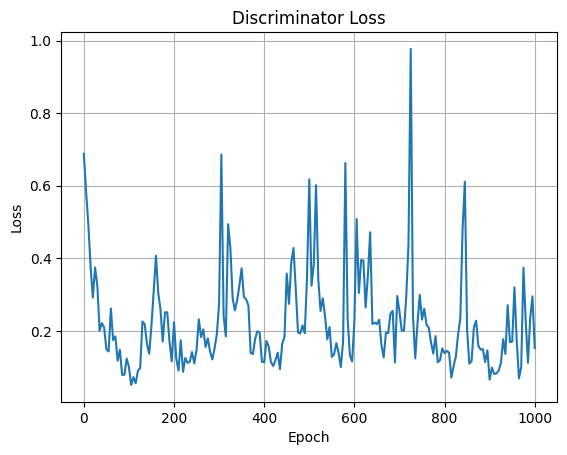

In [96]:
#Train GAN
window_size = 60
latent_dim_GAN = 60
lr = 1e-4
num_epochs = 1001
batch_size = 200
loss_function = nn.BCELoss()
GAN_model = train_GAN(data_train, window_size, latent_dim_GAN, lr, num_epochs, batch_size, loss_function)

Epoch 0, Loss: 0.9751
754
12


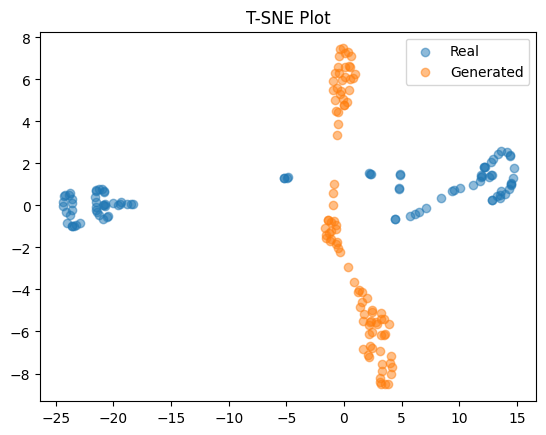

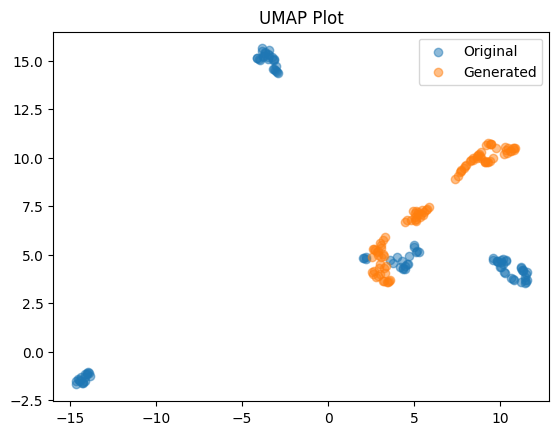

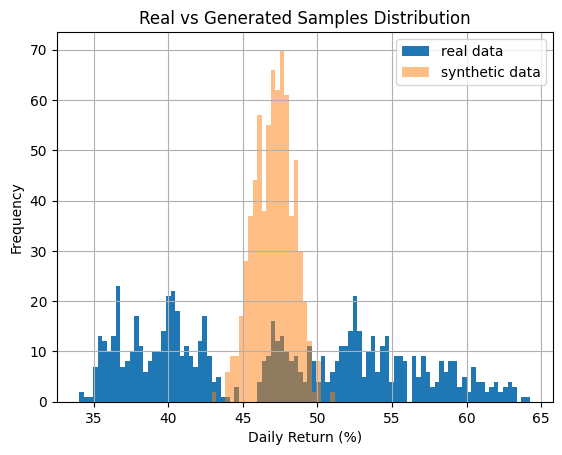

Epoch 250, Loss: 0.0473
754
12


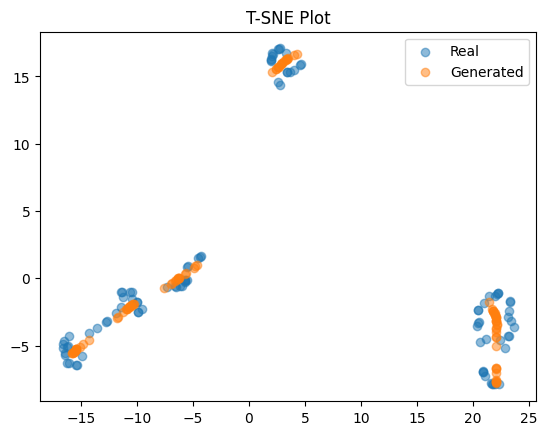

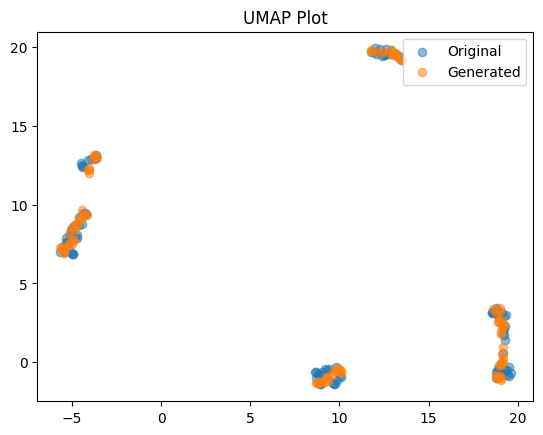

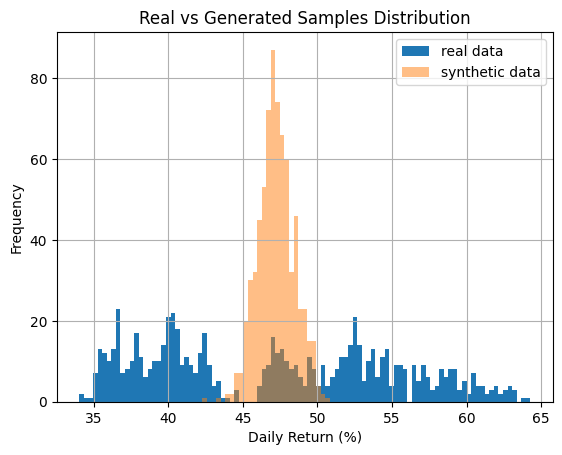

Epoch 500, Loss: 0.0479
754
12


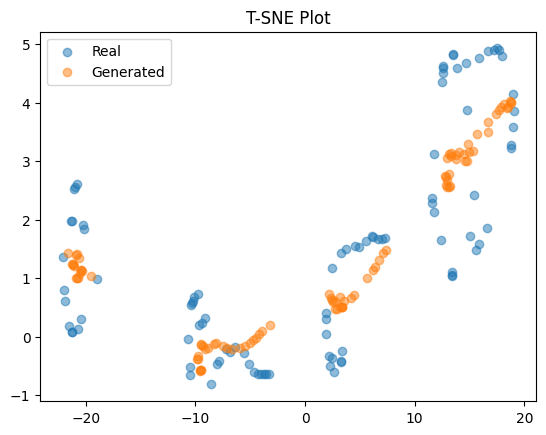

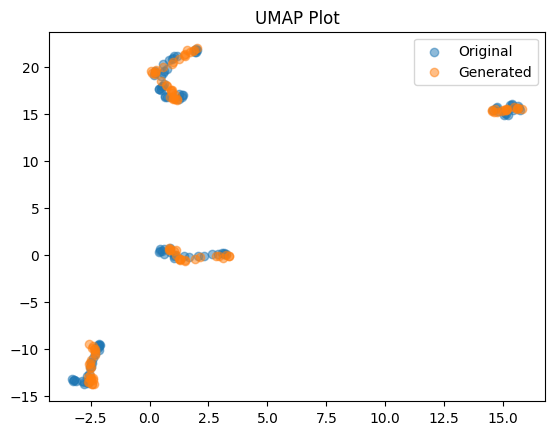

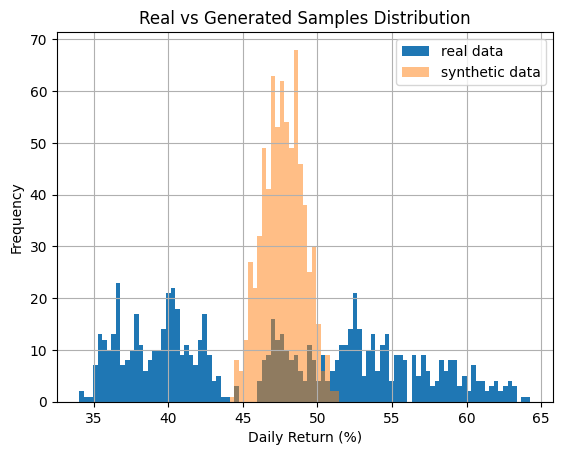

Epoch 750, Loss: 0.0225
754
12


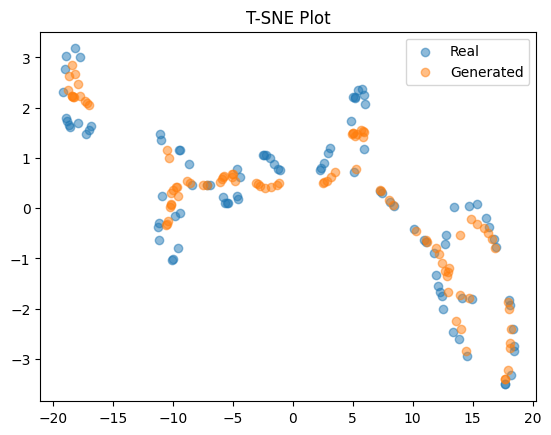

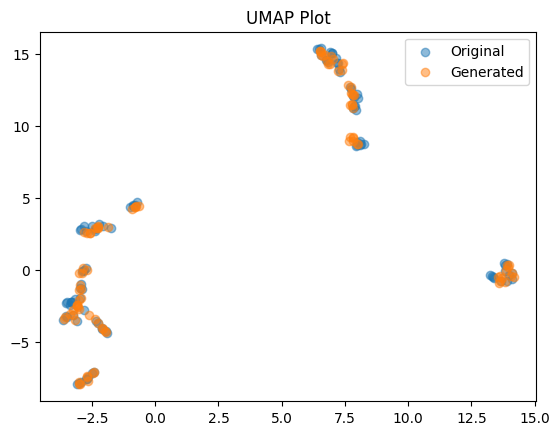

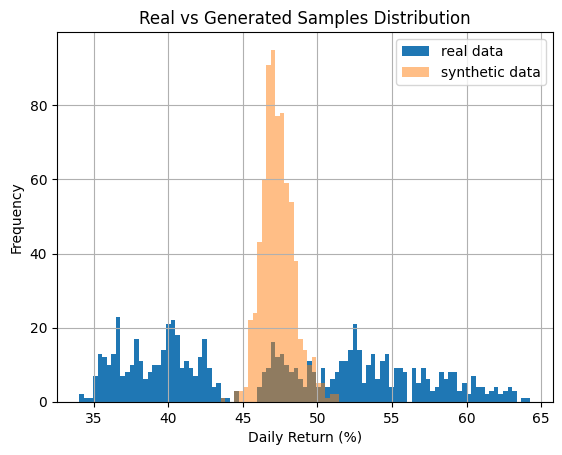

Epoch 1000, Loss: 0.0220
754
12


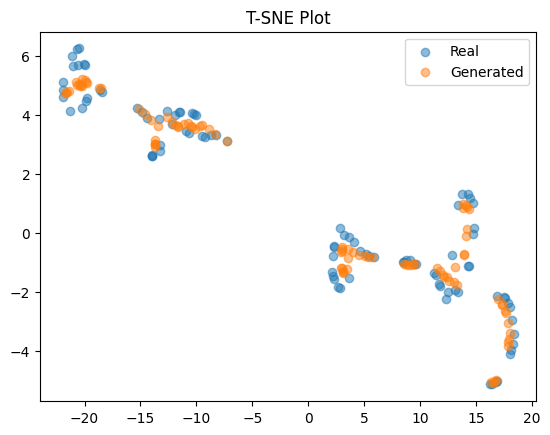

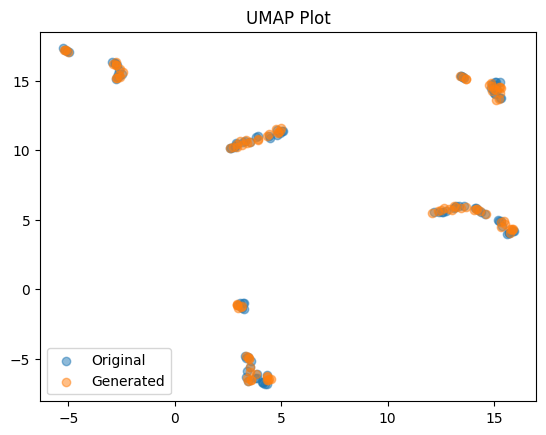

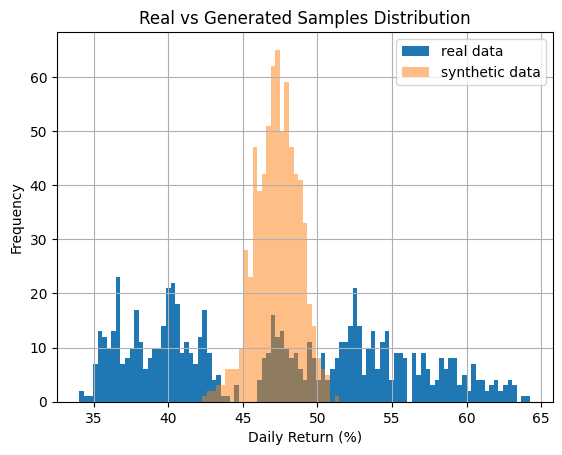

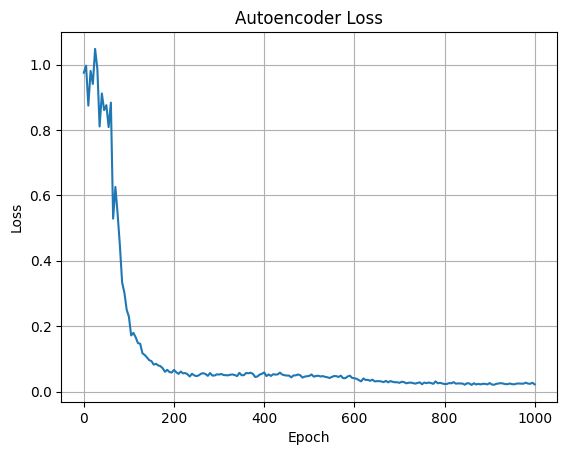

In [38]:
#Train Autoencoder
window_size = 60
latent_dim_AE = 10
lr = 1e-4
num_epochs = 1001
batch_size = 200
loss_function = nn.MSELoss()
AE_model = train_AE(data_train, window_size, latent_dim_AE, lr, num_epochs, batch_size, loss_function)

In [44]:
#Generate Synthetic data for training
lamda = 1 # proportion of synthetic data
num_synthetic = int(lamda*len(data_train))

#Bootstrap
block_length = 10
data_MBB = moving_block_bootstrap(data_train, block_length, num_synthetic)
data_train_MBB = np.concatenate((data_train, data_MBB))

#GAN
data_GAN = GAN_model.generate(num_synthetic, window_size, latent_dim_GAN)
data_train_GAN = np.concatenate((data_train, data_GAN))

#Autoencoder
data_AE = AE_model.generate(num_synthetic, window_size, latent_dim_AE)
data_train_AE = np.concatenate((data_train, data_AE))

12


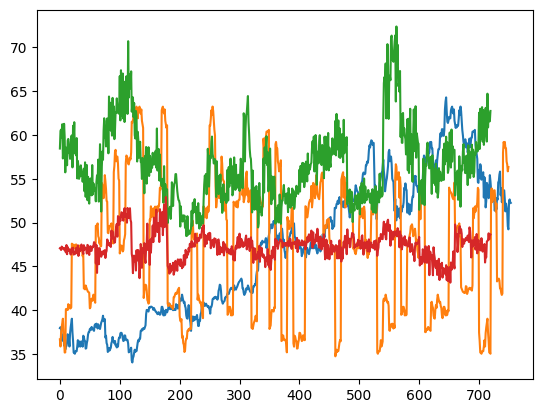

In [46]:
plt.plot(data_train)
plt.plot(data_MBB)
plt.plot(data_GAN)
plt.plot(data_AE)

In [12]:
#Training ARIMA model 
ARIMA_order = (5,0,0)

ARIMA_model_real = train_ARIMA(data_train, ARIMA_order)
data['ARIMA Pct'], data['ARIMA Price'] = predict_ARIMA(data, ARIMA_order[0], 'Close', 'Pct Change', ARIMA_order, train_index, test_index, ARIMA_model_real)

ARIMA_model_MBB = train_ARIMA(data_train_MBB, ARIMA_order)
data['ARIMA Pct MBB'], data['ARIMA Price MBB'] = predict_ARIMA(data, ARIMA_order[0], 'Close', 'Pct Change', ARIMA_order, train_index, test_index, ARIMA_model_MBB)

ARIMA_model_GAN = train_ARIMA(data_train_GAN, ARIMA_order)
data['ARIMA Pct GAN'], data['ARIMA Price GAN'] = predict_ARIMA(data, ARIMA_order[0], 'Close', 'Pct Change', ARIMA_order, train_index, test_index, ARIMA_model_GAN)

ARIMA_model_AE = train_ARIMA(data_train_AE, ARIMA_order)
data['ARIMA Pct AE'], data['ARIMA Price AE'] = predict_ARIMA(data, ARIMA_order[0], 'Close', 'Pct Change', ARIMA_order, train_index, test_index, ARIMA_model_AE)


In [13]:
# plt.figure()
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['Close'], label='Actual')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Price'], label='Prediction with only real data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Price MBB'], label='Prediction with real and MBB data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Price GAN'], label='Prediction with real and GAN data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Price AE'], label='Prediction with real and AE data')
# plt.title('Actual Price and ARIMA Prediction', fontsize=14)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Close', fontsize=14)
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['Pct Change'], label='Actual')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Pct'], label='Prediction with only real data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Pct MBB'], label='Prediction with real and MBB data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Pct GAN'], label='Prediction with real and GAN data')
# plt.plot(data.iloc[i2019:i2023]['Date'], data.iloc[i2019:i2023]['ARIMA Pct AE'], label='Prediction with real and AE data')
# plt.title('Actual Price and ARIMA Prediction', fontsize=14)
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Close', fontsize=14)
# plt.grid(True)
# plt.legend()
# plt.show()

MSE_calculation(data, i2019, i2023, 'Close', 'ARIMA Price', 'ARIMA Price MBB', 'ARIMA Price GAN', 'ARIMA Price AE')

array([3.64108624, 3.62311601, 3.64820782, 4.99823828])